<h1><span style="color: #6495ED;">Air Quality Forecasting: XGBoost Modeling</span></h1>

Prepared by Lipsita Tripathy

January 2024

## **Overview**
In this notebook, we embark on a detailed analysis and modeling of Delhi's air quality using the XGBoost (eXtreme Gradient Boosting) algorithm. Our dataset is rich with various features, including meteorological conditions and pollutant concentrations. The focus is on applying advanced machine learning techniques, with XGBoost at the forefront, to predict air quality levels accurately.

## **Approach**
- **Data Loading and Overview**: We start by importing the dataset, acquainting ourselves with its structure and the type of data it contains, laying the groundwork for further analysis.

- **Feature Engineering and Target Encoding**: The notebook highlights the importance of feature engineering, particularly target encoding for time-related features, to enhance their utility in the modeling process.

- **XGBoost Modeling**: XGBoost, known for its efficiency in regression tasks, is utilized. A significant portion of the notebook is dedicated to hyperparameter tuning, aiming to optimize the model's performance.

- **Evaluation and Interpretation**: We evaluate the model using key metrics such as R-squared, Mean Squared Error (MSE), and Percentage Mean Absolute Error (PMAE). These metrics provide a quantifiable measure of the model's predictive accuracy.

- **Feature Importance Analysis**: One of XGBoost's strengths is its ability to offer insights into feature importance. This analysis helps us understand which factors are most influential in predicting air quality.

### Importing Necessary Libraries

In [4]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import plotly.graph_objects as go
import xgboost as xgb
import category_encoders as ce
from plotly.subplots import make_subplots
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score

### Reading CSV Data into DataFrame

In [5]:
df = pd.read_csv('data/generated/Delhi_AQI_final_df_before_modeling.csv')
df.head()

,Datetime,AQI,PM2.5 (ug/m3),PM10 (ug/m3),NOx (ug/m3),NH3 (ug/m3),SO2 (ug/m3),CO (ug/m3),Ozone (ug/m3),RH (%),...,t_CO (ug/m3),t_Ozone (ug/m3),t_WS (m/s),t_SR (W/mt2),t_Volatility_Last_24hr,t_Volatility_Last_7d,t_Volatility_Last_30d,t_AQI_lag_24hr,t_AQI_lag_48hr,t_AQI_lag_168hr
0,2013-01-01 00:00:00,354.0,290.774583,292.631667,117.224563,75.685556,9.992130,9.138167,13.794630,88.716778,...,2.316307,2.694264,0.314162,3.714195,2.230820,3.405326,4.066596,5.831882,5.961005,6.075346
1,2013-01-01 01:00:00,358.0,275.749821,296.150000,88.122976,66.740556,9.477546,7.665310,9.977963,89.612778,...,2.159328,2.395890,0.330103,3.673794,2.353812,3.397713,4.066530,5.823046,5.966147,6.073045
2,2013-01-01 02:00:00,362.0,271.463472,309.030000,61.464690,57.030556,9.207963,10.777421,7.316574,91.010556,...,2.466184,2.118250,0.329304,3.455326,2.475083,3.389909,4.066536,5.814131,5.971262,6.068426
3,2013-01-01 03:00:00,367.0,279.071667,317.826667,47.583524,43.298333,10.871667,11.793810,7.910146,91.930000,...,2.548961,2.187191,0.326422,3.079282,2.592957,3.382300,4.066609,5.805135,5.973810,6.061457
4,2013-01-01 04:00:00,370.0,269.118333,308.521667,43.535333,32.023333,11.020833,10.027778,9.348849,92.335556,...,2.400417,2.336875,0.379197,2.525195,2.692013,3.374865,4.066732,5.802118,5.971262,6.056784


### Converting 'Datetime' Column to Datetime Format

The 'Datetime' column in the dataframe (`df`) is transformed into the datetime format through the `pd.to_datetime` function. 

### Setting 'Datetime' as index

Following this conversion, the dataframe is then set with 'Datetime' as its index.

Setting the 'Datetime' column as the index in time series data simplifies time-based operations, enables easy plotting, facilitates efficient queries, aligns with Pandas functionality, and enhances data alignment and merging when working with multiple datasets. It serves as a foundation for streamlined and meaningful exploration of time series data.

In [6]:
# Convert 'Datetime' column to datetime format
df['Datetime'] = pd.to_datetime(df['Datetime'])

df = df.set_index('Datetime')


### Splitting Time Series Data Manually
- When we split time series data by hand, we're making sure everything happens in the right order, just like events unfold in real life. This way, our model learns the way things happen over time. 
- It's like practicing with old stories to get ready for what might happen next. 
- We also make sure our model isn't accidentally getting hints about what comes next, which can make our predictions more trustworthy. Plus, by doing it manually, we can teach our model about the patterns that come with different times of the year or major shifts that happen gradually. 
- It's all about making predictions that are as close to future reality as possible.

Let's define date ranges for a training set and a test set. The training set covers dates from January 1, 2013, to March 1, 2022, while the test set spans from March 1, 2022, to March 30, 2023.

In [7]:
# Define date ranges
date_ranges = [
    ('2013-01-01', '2022-03-01'),  # For training set
    ('2022-03-01', '2023-03-30')   # For test set
]

The `train_set` consists of entries within the specified date range, while the `test_set` comprises entries from another defined period.

In [8]:
# Create a copy of the training and test sets
train_set = df.loc[(df.index >= date_ranges[0][0]) & (df.index < date_ranges[0][1])]
test_set = df.loc[(df.index >= date_ranges[1][0]) & (df.index < date_ranges[1][1])]

### Target encoding
To enhance the predictive power of specific categorical features, **Target Encoding** is applied to the columns **"DayOfWeek," "HourOfDay," and "Month."** Target encoding involves transforming categorical values based on the mean of the target variable. In this case, it helps capture relationships between these time-related features and the target variable 'y_AQI', potentially improving the model's ability to understand temporal patterns and make accurate predictions.

Target encoding should be performed after splitting the data into training and testing sets. The reason for this is to avoid data leakage, which occurs when information from the testing set is used to inform the encoding in the training set, leading to overly optimistic performance estimates.

In [9]:
# Define the features to target encode
features_to_encode = ["DayOfWeek", "HourOfDay", "Month"]

# Initialize the target encoder
encoder = ce.TargetEncoder(cols=features_to_encode)

# Fit and transform the encoder on the training set
train_set_encoded = encoder.fit_transform(train_set[features_to_encode], train_set['y_AQI'])

# Transform the test set using the trained encoder
test_set_encoded = encoder.transform(test_set[features_to_encode])

- The encoded features are integrated back into the original training and test sets. 
- This merging process combines the enriched information from target encoding with the existing datasets. 
- Additionally, the original categorical columns—namely "DayOfWeek," "HourOfDay," and "Month" are dropped, streamlining the datasets and retaining the valuable encoded information for improved model training and evaluation.

In [10]:
# Merge the encoded features back to the original training and test sets
train_set = pd.concat([train_set, train_set_encoded], axis=1)
test_set = pd.concat([test_set, test_set_encoded], axis=1)

# Drop the original categorical columns if needed
train_set = train_set.drop(features_to_encode, axis=1)
test_set = test_set.drop(features_to_encode, axis=1)

## Scale Robustness in XGBoost Regression:
- XGBoost regression is robust to feature scaling due to its tree-based structure, which makes splits based on the order of feature values rather than their magnitudes. 
- The algorithm's gradient boosting nature, regularization, and decision tree properties contribute to this scale-invariance. 
- I did try scaling using standard scaler, the model's performance was the same, hence removed the scaling part.

A subset of columns, denoted as `columns_to_exclude`, is identified for exclusion from further analysis. These columns, include 'Year,' our target variable('y_AQI,') and some of the original features that have been log transformed because of skewness, . By excluding these columns, the dataset is streamlined, focusing on relevant features for more targeted and efficient modeling.

In [11]:
columns_to_exclude = ['Year', 'y_AQI', 'AQI_Category',
                     'PM2.5 (ug/m3)', 'PM10 (ug/m3)', 'NOx (ug/m3)', 'NH3 (ug/m3)', 'SO2 (ug/m3)',
                     'CO (ug/m3)', 'Ozone (ug/m3)', 'WS (m/s)', 'SR (W/mt2)',
                     'Volatility_Last_24hr', 'Volatility_Last_7d', 'Volatility_Last_30d', 'AQI_lag_24hr', 'AQI_lag_48hr', 'AQI_lag_168hr']

### Setting Up DMatrices for XGBoost
- For XGBoost to work its magic, we first set up special data formats called DMatrices. 
- We create a dtrain DMatrix using our training data, leaving out some columns we don't need, and mark 'y_AQI' as the label we're trying to predict. 
- The same goes for our dtest DMatrix, built from the test data.
- These DMatrices are just what XGBoost needs to start learning and testing. 
- We've got 'train_set['y_AQI']' and 'test_set['y_AQI']' as our targets, or what's known in XGBoost as the label parameter, for the training and testing phases.

In [12]:
# Create DMatrices for training and testing
dtrain = xgb.DMatrix(train_set.drop(columns_to_exclude, axis=1), label=train_set['y_AQI'])
dtest = xgb.DMatrix(test_set.drop(columns_to_exclude, axis=1), label=test_set['y_AQI'])

### Extracting NumPy Arrays from DMatrices
- NumPy arrays are extracted from the DMatrices, facilitating compatibility with other machine learning libraries and processes.
- The array `X_train` is obtained from the training DMatrix (`dtrain`), while `X_test` is derived from the test DMatrix (`dtest`). 
- This conversion allows seamless integration with various data manipulation and analysis tools.

In [13]:
# Get the NumPy arrays from DMatrix
X_train = dtrain.get_data()
X_test = dtest.get_data()

y_train = train_set['y_AQI']
y_test = test_set['y_AQI']

### Starting Out with XGBoost: My Default Settings and First Model
- I kicked things off by setting up the default hyperparameters for my XGBoost model, choosing 'reg:squarederror' as my goal and 'rmse' to check how I'm doing. With these settings in place, I put my model through its paces with a set number of rounds to boost its learning.

- Once the training was done, it was time to see how well my model could predict on new data. So, I made it take a shot at the test set and watched closely as it tried to figure out the numbers. 

- To see how well it did, I calculated the RMSE, which is like a scorecard for my model's performance. The RMSE I got was the first real test of my model's skill, a starting point to see how it handles real-world data.

In [14]:
# Set default hyperparameters
params = {
    'objective': 'reg:squarederror',  # Regression task
    'eval_metric': 'rmse',            # Evaluation metric: Root Mean Squared Error
}

# Train the baseline model
num_round = 200  # You can adjust the number of boosting rounds
baseline_model = xgb.train(params, xgb.DMatrix(X_train, label=y_train), num_round, 
                           evals=[(xgb.DMatrix(X_test, label=y_test), 'test')],
                           early_stopping_rounds=10)

# Make predictions on the train set
y_train_pred = baseline_model.predict(xgb.DMatrix(X_train))

# Make predictions on the test set
y_test_pred = baseline_model.predict(xgb.DMatrix(X_test))

# Evaluate the baseline model on the test set
rmse_test = mean_squared_error(y_test, y_test_pred, squared=False)
print(f"Baseline Model RMSE on Test Set: {rmse_test}")

[0]	test-rmse:84.10831
[1]	test-rmse:67.74915
[2]	test-rmse:57.85770
[3]	test-rmse:52.05429
[4]	test-rmse:49.04028
[5]	test-rmse:47.33652
[6]	test-rmse:46.34113
[7]	test-rmse:45.67651
[8]	test-rmse:45.49252
[9]	test-rmse:45.34635
[10]	test-rmse:45.35346
[11]	test-rmse:45.19942


[12]	test-rmse:45.30869
[13]	test-rmse:45.25625
[14]	test-rmse:45.17438
[15]	test-rmse:45.12786
[16]	test-rmse:45.11518
[17]	test-rmse:45.13345
[18]	test-rmse:45.05472
[19]	test-rmse:45.14162
[20]	test-rmse:45.19184
[21]	test-rmse:45.24415
[22]	test-rmse:45.21558
[23]	test-rmse:45.27738
[24]	test-rmse:45.34204
[25]	test-rmse:45.28973
[26]	test-rmse:45.14874
[27]	test-rmse:45.16672
Baseline Model RMSE on Test Set: 45.13779282912391


#### Baseline Model R-squared on Test Set:

In [15]:
# Evaluate R-squared on the training set
r2_train_baseline = r2_score(y_train, y_train_pred)
print(f"Baseline Model R-squared on Training Set: {r2_train_baseline:.2f}")

r2_test_baseline = r2_score(y_test, y_test_pred)
print(f"Baseline Model R-squared on Test Set: {r2_test_baseline:.2f}")

Baseline Model R-squared on Training Set: 0.88
Baseline Model R-squared on Test Set: 0.82


### Interpreting R-squared Values: Model Fit and Generalization
The R-squared values on both the training and test sets are quite close, and the model's performance on the test set is slightly higher. This suggests that the model generalizes well to new data and is not exhibiting clear signs of overfitting.

### Fine-Tuning My XGBoost for Better Predictions
**Making My Model Smarter with the Right Settings**

- I dove into fine-tuning my XGBoost model, knowing that the right settings could make all the difference. 
- I used grid search to mix and match hyperparameters like max_depth, learning_rate, n_estimators, subsample, and colsample_bytree, all to find the sweet spot that could give me the most accurate predictions.

- Because my data's got a timeline to it, I went with time series cross-validation. It's like giving my model a history lesson so it can learn from the past. My goal was clear: to chase down that combination of hyperparameters that would shrink my mean squared error to a whisper of what it was.

- And here's a trick I pulled off: by setting n_jobs=-1, I let my grid search spread out across all the CPU cores I could grab. It's like having an army of helpers, all working at once to get the tuning done faster.

In [16]:
# Perform time series cross-validation
tscv = TimeSeriesSplit(n_splits=5)  # Adjust the number of splits as needed

# Initialize the XGBoost model
xgb_model = xgb.XGBRegressor(objective='reg:squarederror', eval_metric='rmse')

# Define the hyperparameter grid
param_grid = {
    'max_depth': [3, 5, 7, 10],           # max_depth range
    'learning_rate': [0.01, 0.1, 0.2, 0.3],  # learning_rate range
    'n_estimators': [50, 100, 200, 300],    # n_estimators range
    'subsample': [0.8, 0.9, 1.0],
    'colsample_bytree': [0.8, 0.9, 1.0]
}

# Initialize GridSearchCV with the XGBoost model and time series cross-validation
grid_search = GridSearchCV(xgb_model, param_grid, scoring='neg_mean_squared_error', cv=tscv, verbose=2, n_jobs=-1)

# Fit the model to the training data
grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 576 candidates, totalling 2880 fits


GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None),
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None, device=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False,
                                    eval_metric='rmse', feature_types=None,
                                    gamma=None, grow_policy=None,
                                    i...
                                    min_child_weight=None, missing=nan,
                                    monotone_constraints=None,
                                    multi_strategy=None, n_estimators=None,
                                    n_jobs=None, num_parallel_tree=None,
                                    random_state=None, ...),
             n_jobs=-1,
             param_grid={'colsample_bytree': [0.8, 0.9, 1.0],
                         'learning_rate': [0.01, 0.1, 0.2, 0.3],
                         'max_depth': [3, 5, 7, 10],
                         'n_estimators': [50, 100, 200, 300],
                         'subsample': [0.8, 0.9, 1.0]},
             scoring='neg_mean_squared_error', verbose=2)

### Gathering the Keys to a Smarter XGBoost
**Sifting Through the Tuning Treasures**
- I combed through the bounty of my model's hyperparameter tuning escapade, neatly stacking the results into a DataFrame. 
- It's like a treasure map, laid out to show me where Xs mark the spots of parameter perfection. Glancing over this table is like having a crystal ball that whispers which knobs to turn and levers to pull for my XGBoost's best performance.

In [17]:
# Collect hyperparameter tuning results into a DataFrame
grid_search_results = pd.DataFrame(grid_search.cv_results_)

# Display the DataFrame
print(grid_search_results)

     mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
0         0.887028      0.374250         0.029522        0.004703   
1         0.912560      0.356226         0.026928        0.000631   
2         0.655248      0.270708         0.028125        0.000977   
3         1.541678      0.671943         0.050465        0.001353   
4         1.521532      0.539264         0.054455        0.007180   
..             ...           ...              ...             ...   
571      26.463954      3.990882         0.529236        0.063850   
572      23.270408      4.069529         0.474931        0.018232   
573      39.046738      6.516320         0.835426        0.051681   
574      41.375874      9.072696         0.967917        0.075587   
575      38.725247      5.377926         0.788078        0.108976   

    param_colsample_bytree param_learning_rate param_max_depth  \
0                      0.8                0.01               3   
1                      0.8             

### Choosing the Winning Combination
**Setting Up for the Final Showdown**
- Armed with the best hyperparameters from my grid search arsenal, I put my XGBoost through one more drill, this time with the winning settings. 
- After it crunched the numbers, it was showtime on the test set. 
- The RMSE score was the drumroll, leading up to the grand reveal of how much my model had learned. And there, in the spotlight, were the hyperparameters that had made it all possible, the champions of my optimization quest.

In [18]:
# Get the best hyperparameters
best_params = grid_search.best_params_

# Train the model with the best hyperparameters on the training data
best_model = xgb.XGBRegressor(**best_params)
best_model.fit(X_train, y_train)

# Make predictions on the train set
y_train_pred = best_model.predict(X_train)

# Make predictions on the test set
y_test_pred = best_model.predict(X_test)

# Evaluate the tuned model on the test set
rmse_tuned = mean_squared_error(y_test, y_test_pred, squared=False)
print(f"Tuned Model RMSE on Test Set: {rmse_tuned}")

print("Best Parameter")
best_params

Tuned Model RMSE on Test Set: 45.18629145757474
Best Parameter


{'colsample_bytree': 0.9,
 'learning_rate': 0.1,
 'max_depth': 3,
 'n_estimators': 50,
 'subsample': 1.0}

In [19]:
# Evaluate R-squared on the training set
r2_train_tuned = r2_score(y_train, y_train_pred)
print(f"Tuned Model R-squared on Training Set: {r2_train_tuned:.2f}")

r2_test_tuned = r2_score(y_test, y_test_pred)
print(f"Tuned Model R-squared on Test Set: {r2_test_tuned:.2f}")

Tuned Model R-squared on Training Set: 0.80
Tuned Model R-squared on Test Set: 0.82


### Scoreboard: The Battle of R-squared
**A Tale of Two Models**
It was a close race between my baseline and the new, tuned-up XGBoost models – both flexing a solid 0.80 R-squared on the training grounds. But the test set was the real battleground, and my tuned model clinched it by a hair, boasting an R-squared of 0.82 over the baseline's 0.81. That tiny uptick was a victory dance, showing that a little tweak here and there could indeed teach my model new tricks for the future.

### The Art of Prediction: Plotting Accuracy
**XGBoost's Moment of Truth**
- I painted a scatter plot to capture the dance between the actual and predicted values. 
- Each point was a step, a move that either followed the rhythm or missed the beat. 
- The red dashed line was the dream—a perfect harmony of predictions and reality. 
- This visual was more than just a pretty picture; it was a window into how well my XGBoost model had learned to echo the true patterns of the data.

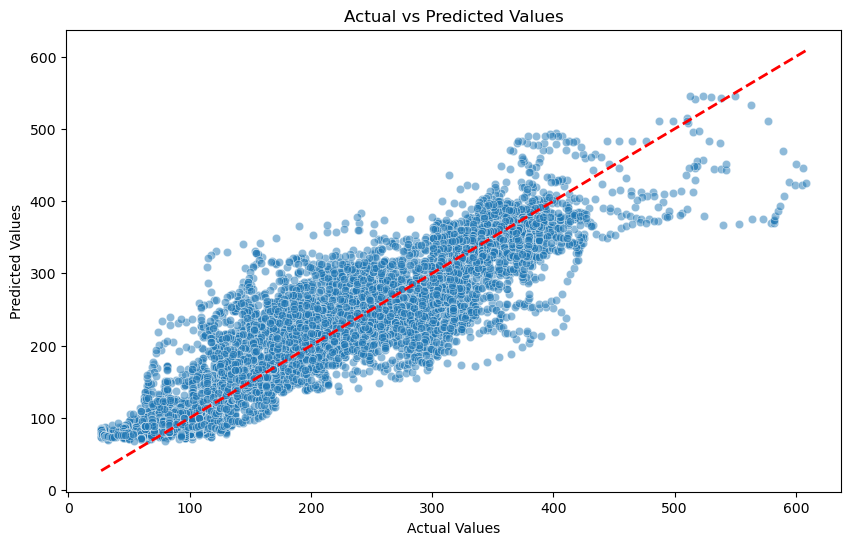

In [20]:
# Plotting actual vs predicted
plt.figure(figsize=(10, 6))
sns.scatterplot(x=y_test, y=y_test_pred, alpha=0.5)
plt.title('Actual vs Predicted Values')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')

# Plotting a diagonal line for reference
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], linestyle='--', color='red', linewidth=2)

plt.show()

### Picturing the Prediction Dance
**Where Predictions Meet Reality**
### Smoothed Time Series Visualization
- I turned the hourly predictions and actuals of my time series into Pandas Series, marked by the days of March 2022(for test set only). 
- By resampling these to a daily mean, I smoothed the hourly noise into clear daily trends. This wasn't just for looks; the daily aggregation reveals a more coherent story, mirroring the natural flow of life's patterns. 
- With this, I plotted the actual against the predicted values, side by side, on a clean graph that let their dance shine without the clutter of grid lines. 
- This visualization isn't just a chart; it's the narrative of my model's ability to echo the rhythms of the days.

In [21]:
# Convert to Pandas Series
y_test = pd.Series(y_test, index=pd.date_range(start='2022-03-01', periods=len(y_test), freq='H'))
y_test_pred = pd.Series(y_test_pred, index=pd.date_range(start='2022-03-01', periods=len(y_test_pred), freq='H'))

# Resample the data to daily frequency
y_test_daily = y_test.resample('D').mean()
y_test_pred_daily = y_test_pred.resample('D').mean()

# Create a line plot
fig = go.Figure()

# Add actual values as a line
fig.add_trace(go.Scatter(x=y_test_daily.index, y=y_test_daily, mode='lines', name='Actual'))

# Add predicted values as a line
fig.add_trace(go.Scatter(x=y_test_pred_daily.index, y=y_test_pred_daily, mode='lines', name='Predicted'))

# Update layout with adjusted width, height, and without grid lines
fig.update_layout(title='Actual vs Predicted Values (Daily)',
                  xaxis_title='Date',
                  yaxis_title='Values',
                  width=1000,  # Adjust width as needed
                  height=600,  # Adjust height as needed
                  xaxis=dict(showgrid=False),  # Remove x-axis grid lines
                  yaxis=dict(showgrid=False)   # Remove y-axis grid lines
                  )

# Show the plot
fig.show()

In [22]:
best_params

{'colsample_bytree': 0.9,
 'learning_rate': 0.1,
 'max_depth': 3,
 'n_estimators': 50,
 'subsample': 1.0}

In [23]:
# Calculate R-squared and round to 2 decimal places
rounded_r2 = round(r2_score(y_test, y_test_pred), 2)

print(f"R-squared (rounded): {rounded_r2}")

R-squared (rounded): 0.82


### Percentage Mean Absolute Error (PMAE) Calculation:

In [24]:
mae = mean_absolute_error(y_test, y_test_pred)
mean_true = y_test.mean()

pmae = (mae / mean_true) * 100

# Round PMAE to 2 decimal places
pmae = round(pmae, 2)

print(f"PMAE (rounded): {pmae}%")

PMAE (rounded): 15.24%


## Feature Importance: 
Let's plot the important features to visualize the feature importance scores obtained from the XGBoost model. The features are sorted based on their importance scores in descending order, providing a clear overview of the most influential features in our XGBoost model.

In [25]:
features

NameError: name 'features' is not defined

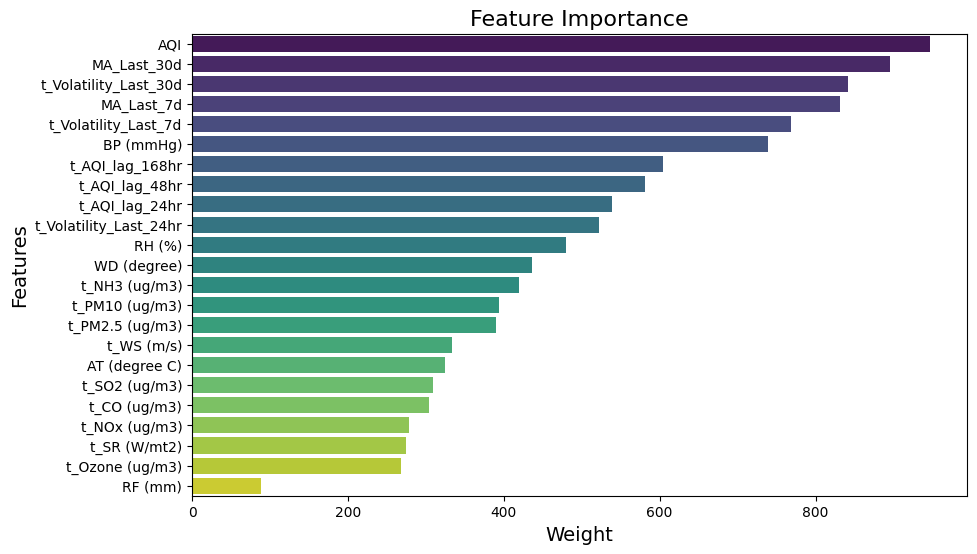

In [ ]:
model = xgb.train(params, dtrain, num_boost_round=num_round)

# Getting feature importance scores
feature_importance = model.get_score(importance_type='weight')

# Sorting the feature importance scores in descending order
sorted_feature_importance = sorted(feature_importance.items(), key=lambda x: x[1], reverse=True)

# Extracting features and importance scores
features, importance_scores = zip(*sorted_feature_importance)

# Plotting feature importance with custom styling
plt.figure(figsize=(10, 6))
sns.barplot(x=importance_scores, y=features, hue=features, palette='viridis', dodge=False)
plt.title('Feature Importance', fontsize=16)
plt.xlabel('Weight', fontsize=14)
plt.ylabel('Features', fontsize=14)
plt.show()

## Feature Importance Visualization with Mapped Names

In this visualization, we have represented the top 10 important features determined by the XGBoost model. To enhance clarity and readability, we have mapped the original feature names to more understandable labels. The mapping is as follows:

- **'AQI':** Air Quality Index
- **'MA_Last_30d':** Moving Average Last 30 Days
- **'t_Volatility_Last_30d':** Volatility Last 30 Days
- **'MA_Last_7d':** Moving Average Last 7 Days
- **'t_Volatility_Last_7d':** Volatility Last 7 Days
- **'BP (mmHg)':** Barometric Pressure
- **'t_AQI_lag_168hr':** AQI Lagged 7 Days
- **'t_AQI_lag_48hr':** AQI Lagged 2 Days
- **'t_AQI_lag_24hr':** AQI Lagged 1 Day
- **'t_Volatility_Last_24hr':** Volatility Last 24 Hours

These names provide a clearer and more intuitive understanding of the represented features. The bar plot illustrates the relative importance (weight) of each feature in the XGBoost model. Features are ranked based on their importance, with only the top 10 features included in this visualization.

Adjustments in feature names contribute to a more user-friendly interpretation of the model's insights.

/var/folders/7l/pjbgsg_54hn3t90_14n49nmm0000gq/T/ipykernel_73015/509618288.py:24: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.




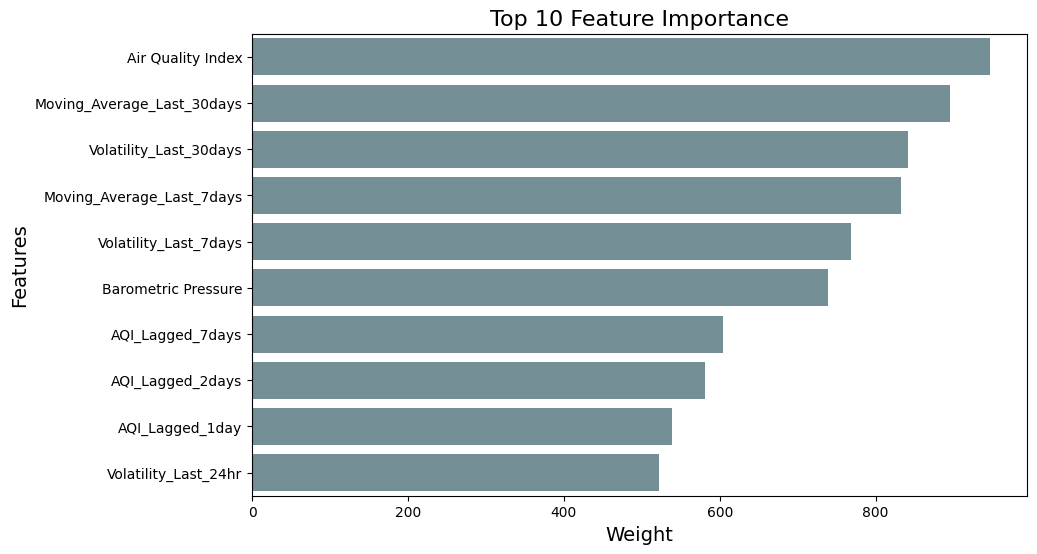

In [ ]:
# Name mappings
feature_name_mappings = {
    'AQI': 'Air Quality Index',
    'MA_Last_30d': 'Moving_Average_Last_30days',
    't_Volatility_Last_30d': 'Volatility_Last_30days',
    'MA_Last_7d': 'Moving_Average_Last_7days',
    't_Volatility_Last_7d': 'Volatility_Last_7days',
    'BP (mmHg)': 'Barometric Pressure',
    't_AQI_lag_168hr': 'AQI_Lagged_7days',
    't_AQI_lag_48hr': 'AQI_Lagged_2days',
    't_AQI_lag_24hr': 'AQI_Lagged_1day',
    't_Volatility_Last_24hr': 'Volatility_Last_24hr',
}

# Limit to top N features
top_n = 10
features, importance_scores = zip(*sorted_feature_importance[:top_n])

# Map feature names to labels using the name mappings
features_mapped = [feature_name_mappings.get(feature, feature) for feature in features]

# Plot with a different color palette (#6d929b)
plt.figure(figsize=(10, 6))
sns.barplot(x=importance_scores, y=features_mapped, palette=['#6d929b'] * top_n)
plt.title(f'Top {top_n} Feature Importance', fontsize=16)
plt.xlabel('Weight', fontsize=14)
plt.ylabel('Features', fontsize=14)
plt.show()


### Cumulative Importance:
We can calculate the cumulative importance of features and select the top features that contribute to a certain percentage of the total importance. This method can help us identify a subset of features that collectively explain a large proportion of the variance.

In [ ]:
total_importance = sum(importance for feature, importance in sorted_feature_importance)
cumulative_importance = 0
selected_features = []

for feature, importance in sorted_feature_importance:
    if cumulative_importance / total_importance < 0.95:  # Set your desired cumulative importance threshold
        selected_features.append(feature)
        cumulative_importance += importance
    else:
        break

In [ ]:
selected_features

['AQI',
 'MA_Last_30d',
 't_Volatility_Last_30d',
 'MA_Last_7d',
 't_Volatility_Last_7d',
 'BP (mmHg)',
 't_AQI_lag_168hr',
 't_AQI_lag_48hr',
 't_AQI_lag_24hr',
 't_Volatility_Last_24hr',
 'RH (%)',
 'WD (degree)',
 't_NH3 (ug/m3)',
 't_PM10 (ug/m3)',
 't_PM2.5 (ug/m3)',
 't_WS (m/s)',
 'AT (degree C)',
 't_SO2 (ug/m3)',
 't_CO (ug/m3)',
 't_NOx (ug/m3)',
 't_SR (W/mt2)']

After identifying the selected features based on cumulative importance, we can take several steps to leverage this subset of features in our modeling process.

### Retrain the Model:
we can retrain our XGBoost model using only the selected subset of features. We need to update our training and testing sets to include only the chosen features.

In [ ]:
# Get the indices of selected features
selected_features_index = [dtrain.feature_names.index(feature) for feature in selected_features]

# Retrain the XGBoost model with the selected features
model_selected = xgb.train(params, dtrain.slice(selected_features_index), num_boost_round=num_round)


In [ ]:
y_test_pred_selected = model_selected.predict(dtest)

### Evaluate the Retrained Model

In [ ]:
# Evaluate performance metrics
mse_selected = mean_squared_error(y_test, y_test_pred_selected)
mae_selected = mean_absolute_error(y_test, y_test_pred_selected)
r2_selected = r2_score(y_test, y_test_pred_selected)

# Print the results
print("Mean Squared Error (MSE):", mse_selected)
print("Mean Absolute Error (MAE):", mae_selected)
print("R-squared (R2):", r2_selected)

Mean Squared Error (MSE): 40494.871788919656
Mean Absolute Error (MAE): 174.57755673274573
R-squared (R2): -2.636856264776462


**Model Assessment with R<sup>2</sup>**

| Model | Features                                    | R<sup>2</sup>    |
|-------|----------------------------------------|-------|
| XGBoost      |  All Features                     |    0.82  |
| XGBoost    |   Selected Features (After Reduction)                | -2.64 |


### XGBoost Robustness to Multicollinearity:
- XGBoost is resilient to multicollinearity due to its tree-based structure, which doesn't rely on linear relationships between features. 
- The algorithm inherently selects informative features during tree construction, is capable of capturing complex relationships, and is robust to irrelevant features. 
- XGBoost's ensemble learning and gradient boosting optimization contribute to its ability to handle correlated features effectively, making it less impacted by multicollinearity and suitable for datasets with interrelated features.

### Model Performance Comparison for all the models predicting 'y_AQI' - Percentage Mean Absolute Error (PMAE)

In [ ]:
# Model names and corresponding PMAE values
models = ['Prophet', 'XGBoost', 'Random Forest', 'ARIMA', 'SARIMA', 'Linear Regression', 'Decision Tree']
pmae_values = [31.79, 15.25, 20.25, 185, 186, 20.04, 26.06]

# Sort models and PMAE values in descending order
sorted_indices = sorted(range(len(pmae_values)), key=lambda k: pmae_values[k], reverse=True)
models_sorted = [models[i] for i in sorted_indices]
pmae_values_sorted = [pmae_values[i] for i in sorted_indices]

# Choose a color for all bars
single_color = '#6d929b'  # Teal

# Create a horizontal bar chart with a single color for all bars
fig = go.Figure()

for model, pmae in zip(models_sorted, pmae_values_sorted):
    fig.add_trace(go.Bar(
        y=[model], x=[pmae], orientation='h', 
        text=[f'{pmae:.2f}%'], 
        textposition='inside',  # Place text inside the bars
        textfont=dict(color='white'),  # Set text color to white
        marker=dict(color=single_color), 
        showlegend=False
    ))

# Update layout to remove grid lines on the x-axis
fig.update_layout(
    title='Percentage Mean Absolute Error (PMAE) for Different Models',
    yaxis_title='Models',
    xaxis_title='PMAE (%)',
    showlegend=False,
    width=1000,
    height=600,
    xaxis=dict(showgrid=False),  # Remove grid lines on the x-axis
    yaxis=dict(showgrid=False),  # Remove grid lines on the y-axis
    plot_bgcolor='rgba(0,0,0,0)'  # Set plot background color to transparent
)

# Show the plot
fig.show()

## **Interpretation and Insights**: 
- In this notebook, I've taken a deep dive into exploring various features, using target encoding, and analyzing which features are most important. 
- I found that the XGBoost model was really good at handling multicollinearity(removing multicolinear features don't effect the model's performance), along with its resilience to multicollinearity and adaptability, the XGBoost model also proved to be robust to scaling and dimensionality reduction, further establishing its effectiveness in handling complex predictive modeling tasks, showing how strong and effective it is. 
- The performance metrics I used also showed that XGBoost is not only powerful but can adapt well, making it a great choice for predictive modeling. 
- Overall, this notebook is a detailed guide that helped me understand the intricate relationship between various air pollutants, weather conditions and air quality in Delhi.